In [1]:
import numpy as np
import matplotlib.pyplot as plt
from MDAnalysis import *
import matplotlib as mpl
from matplotlib import cm
from scipy import optimize
mpl.rcParams['axes.linewidth'] = 1.4
Z=20
import pandas as pd
from scipy.stats import spearmanr, kendalltau, pearsonr
import math
from matplotlib.ticker import FormatStrFormatter
import random
import seaborn as sns
from scipy.stats import norm
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import confusion_matrix, accuracy_score
import graphviz 
LOGACT_THRES=1.0

In [2]:
#EXP=Affinity constant, std, ranking
EXP = {"N8A20": [0, 0],
      "N14A20": [0, 0],
      "N9A20" : [0, 0],
      "N6A21" : [0, 0],
      "N1A16" : [0, 0],
      "N1A17" : [0, 0],
      "N3A10" : [0, 0],
      "N3A11" : [0, 0],
      "N3A18" : [0, 0],
      "N6A20" : [120, 5],
      "N15A20": [300, 0],
      "N7A20" : [1100, 0],
      "N16A20": [4.5*10**4, 0],
      "N13A20": [5.0*10**4, 0],
      "N2A11" : [8.5*10**4, 1.5*10**4],
      "N2A10" : [9.3*10**4, 1.2*10**4],
      "N1A9"  : [1.2*10**5, 0.2*10**5],
      "N1A8"  : [1.3*10**5, 0.2*10**5],
      "N1A7"  : [2.6*10**5, 0.6*10**5],
      "N1A13" : [2.7*10**5, 0.3*10**5],
      "N1A1"  : [3.6*10**5, 0],
      "N3A19" : [3.6*10**5, 0.1*10**5],
      "N1A15" : [3.7*10**5, 0],
      "N1A12" : [3.9*10**5, 0.3*10**5],
      "N1A10" : [4.1*10**5, 0.4*10**5],
      "N1A14" : [4.6*10**5, 0],
      "N1A11" : [4.8*10**5, 0.5*10**5],
      "N2A18" : [5.1*10**5, 0.3*10**5],   
      "N1A18" : [6.1*10**5, 1.4*10**5],
      "N2A19" : [1.3*10**6, 0.1*10**6],
      "N1A19" : [2.2*10**6, 0.1*10**6],
      }

Ns = [int(key.split('A')[0].split("N")[1]) for key in EXP.keys()]
As = [int(key.split('A')[1]) for key in EXP.keys()]
Systems = ["N{}A{}".format(n,a) for n,a in zip(Ns, As)]
act_mean = [EXP["N{}A{}".format(n, a)][0] for n, a in zip(Ns, As)]
act_std = [EXP["N{}A{}".format(n, a)][1] for n, a in zip(Ns, As)]
act_rank = np.argsort(-1*np.array(act_mean))

colors = np.round(cm.rainbow(np.linspace(0, 1, len(Ns))), 2)
colnames = ['Nanoparticle', 'Analyte', 'Act_Mean', 'Act_Std', 'Act_Rank', 'Color']
DATA = pd.DataFrame(zip(Ns, As, act_mean, act_std, act_rank, colors), columns=colnames, index=Systems)
DATA.index.name = "System"
print(len(EXP))

31


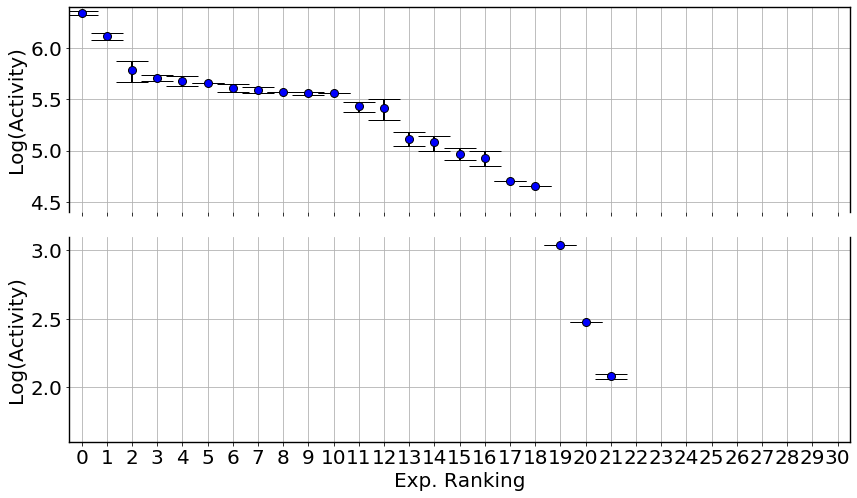

In [3]:
act_means = DATA.Act_Mean.values*1
act_means[act_means==0] = 1.0
act_stds = DATA.Act_Std.values*1
log_means = np.log10(act_means)
DATA['Act_log'] = log_means
err_up = np.log10(act_means+act_stds) - np.log10(act_means)
err_down = np.log10(act_means) - np.log10(act_means-act_stds)
error = np.array([err_down, err_up])
DATA['Act_log_error_up'] = err_up
DATA['Act_log_error_down'] = err_down

subplot_kw={'xlim':(-0.5, max(DATA.Act_Rank)+0.5), 'xticks':np.linspace(0,max(DATA.Act_Rank), max(DATA.Act_Rank)+1)}
fig, axs = plt.subplots(figsize=(14,8), sharex=True, ncols=1, nrows=2, subplot_kw=subplot_kw, gridspec_kw={'hspace':0.12, 'wspace':0.0})
plt.xlabel("Log(Binding constant)", fontsize=Z)
for ax in axs:
    ax.grid()
    ax.set_ylabel("Log(Activity)", fontsize=Z)
    ax.tick_params(labelsize=Z)
    ax.errorbar(DATA.Act_Rank, DATA.Act_log, yerr=error, fmt='o', capsize=16, markeredgecolor='k', markeredgewidth=1, markerfacecolor='b', markersize=8, linewidth=2, color='k')
axs[0].set_ylim(4.4,6.4)
axs[0].spines['bottom'].set_visible(False)
axs[1].set_ylim(1.6,3.1)
axs[1].spines['top'].set_visible(False)
axs[-1].set_xlabel("Exp. Ranking", fontsize=Z)
plt.show()
plt.close()

In [4]:
Act_Rank_Std_up = []
Act_Rank_Std_down = []
N = len(DATA)
n_act = np.sum(DATA.Act_Mean > 0.0)
for i in range(N):
    lower_than = np.sum((DATA.Act_Mean[i] + DATA.Act_Std[i]) >= (DATA.Act_Mean[i:]-DATA.Act_Std[i:]))-1 #-1 to not count itself
    Act_Rank_Std_up.append(lower_than)
    greater_than = np.sum((DATA.Act_Mean[i] - DATA.Act_Std[i]) <= (DATA.Act_Mean[:i]+DATA.Act_Std[:i])) #-1 is absent because of slicing open/closed limits
    Act_Rank_Std_down.append(greater_than)
Act_Rank_Std_up = np.array(Act_Rank_Std_up)
DATA['Act_Rank_Std_up'] = Act_Rank_Std_up*1
DATA['Act_Rank_Std_down'] = Act_Rank_Std_down*1
DATA['Act_Rank_Std_up'].loc[DATA.Act_Mean==0.0] = DATA['Act_Rank_Std_down'].loc[DATA.Act_Mean==0.0]*1
DATA['Act_Rank_Std_down'].loc[DATA.Act_Mean==0.0] = Act_Rank_Std_up[DATA.Act_Mean==0.0]*1
DATA['Active'] = DATA['Act_log'] > LOGACT_THRES
LOGACT_NDX = np.where((DATA['Active'] == False))[0][-1]

DATA = DATA[['Nanoparticle', 'Analyte', 'Act_Mean', 'Act_Std', 'Act_Rank', 'Act_Rank_Std_up', 'Act_Rank_Std_down', 'Act_log', 'Act_log_error_up', 'Act_log_error_down', 'Color', 'Active']]
#print(DATA.head())
#print(DATA.tail())
print(DATA[['Act_Mean', 'Act_Rank', 'Act_Rank_Std_up', 'Act_Rank_Std_down', 'Act_log', 'Act_log_error_up', 'Act_log_error_down', 'Active']])

         Act_Mean  Act_Rank  Act_Rank_Std_up  Act_Rank_Std_down   Act_log  \
System                                                                      
N8A20         0.0        30                0                  8  0.000000   
N14A20        0.0        29                1                  7  0.000000   
N9A20         0.0        28                2                  6  0.000000   
N6A21         0.0        27                3                  5  0.000000   
N1A16         0.0        26                4                  4  0.000000   
N1A17         0.0        25                5                  3  0.000000   
N3A10         0.0        24                6                  2  0.000000   
N3A11         0.0        23                7                  1  0.000000   
N3A18         0.0        22                8                  0  0.000000   
N6A20       120.0        21                0                  0  2.079181   
N15A20      300.0        20                0                  0  2.477121   

C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
NP_lonepairs = {1:7, 2:9, 3:9, 5:14, 6:8, 7:8, 8:10, 9:10, 10:8, 11:8, 12:10, 13:8, 14:10, 15:8, 16:0}
NP_hydrogens = {1:0, 2:1, 3:1, 5:1, 6:1, 7:2, 6:1, 7:2, 8:1, 9:2, 10:0, 11:0, 12:2, 13:3, 14:1, 15:1, 16:3}
AN_lonepairs = {1:0, 6:0, 7:0, 8:2, 9:4, 10:2, 11:2, 12:4, 13:2, 14:5, 15:2, 16:5, 17:7, 18:0, 19:0, 20:7, 21:6}
AN_hydrogens = {1:3, 6:2, 7:4, 8:4, 9:5, 10:3, 11:3, 12:3, 13:5, 14:3, 15:3, 16:3, 17:1, 18:3, 19:3, 20:1, 21:1} #Fluors were included
NP_pcharges = {1:0, 2:0, 3:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:1}
NP_ncharges = {1:1, 2:1, 3:1, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0}
A_pcharges = {1:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1, 15:1, 16:1, 17:0, 18:1, 19:1, 20:0, 21:0}
A_ncharges = {1:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:1, 17:1, 18:0, 19:0, 20:1, 21:1}
NP_arrings = {1:0, 2:1, 3:1, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0}
A_arrings = {1:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:2, 14:1, 15:1, 16:1, 17:1, 18:2, 19:4, 20:1, 21:1}

np_lonepairs = [NP_lonepairs[n] for n in Ns]
np_hydrogens = [NP_hydrogens[n] for n in Ns]
a_lonepairs = [AN_lonepairs[a] for a in As]
a_hydrogens = [AN_hydrogens[a] for a in As]
np_pcharges = [NP_pcharges[n] for n in Ns]
np_ncharges = [NP_ncharges[n] for n in Ns]
a_pcharges = [A_pcharges[a] for a in As]
a_ncharges = [A_ncharges[a] for a in As]
np_arrings = [NP_arrings[n] for n in Ns]
a_arrings = [A_arrings[a] for a in As]

ml_cols = ['NP_lonepairs', 'NP_hydrogens', 'NP_pcharges', 'NP_ncharges', 'NP_arrings', 'A_lonepairs', 'A_hydrogens', 'A_pcharges', 'A_ncharges', 'A_arrings']
X_set = pd.DataFrame(zip(np_lonepairs, np_hydrogens, np_pcharges, np_ncharges, np_arrings, a_lonepairs, a_hydrogens, a_pcharges, a_ncharges, a_arrings), columns=ml_cols, index=Systems)
Y_set = DATA.Active.astype(int)
ml_set = X_set.join(Y_set)

In [6]:
ml_set

,NP_lonepairs,NP_hydrogens,NP_pcharges,NP_ncharges,NP_arrings,A_lonepairs,A_hydrogens,A_pcharges,A_ncharges,A_arrings,Active
N8A20,10,1,0,0,0,7,1,0,1,1,0
N14A20,10,1,0,0,0,7,1,0,1,1,0
N9A20,10,2,0,0,0,7,1,0,1,1,0
N6A21,8,1,0,0,0,6,1,0,1,1,0
N1A16,7,0,0,1,0,5,3,1,1,1,0
N1A17,7,0,0,1,0,7,1,0,1,1,0
N3A10,9,1,0,1,1,2,3,1,0,1,0
N3A11,9,1,0,1,1,2,3,1,0,1,0
N3A18,9,1,0,1,1,0,3,1,0,2,0
N6A20,8,1,0,0,0,7,1,0,1,1,1


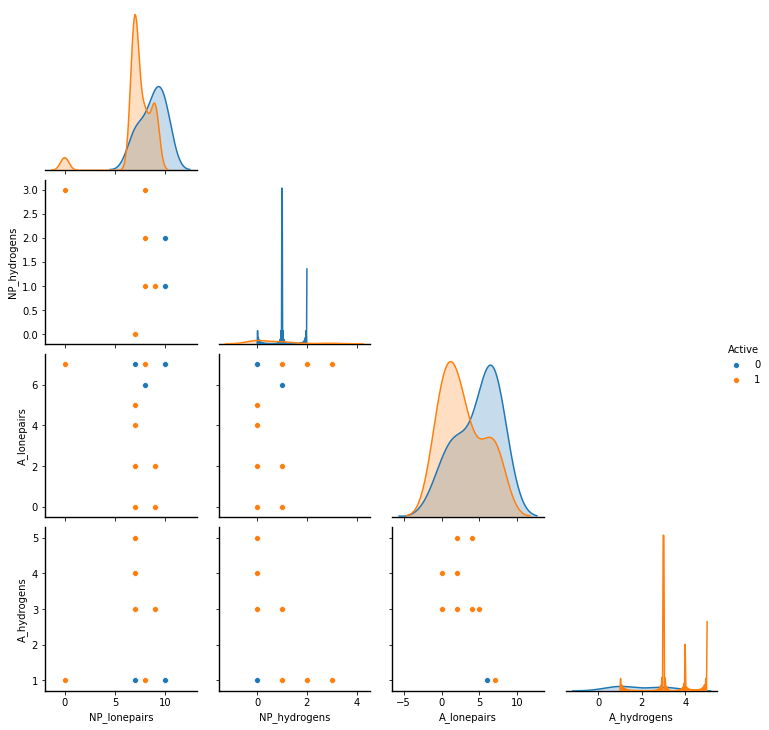

In [7]:
g = sns.pairplot(ml_set, hue='Active', x_vars=['NP_lonepairs', 'NP_hydrogens', 'A_lonepairs', 'A_hydrogens'], y_vars=['NP_lonepairs', 'NP_hydrogens', 'A_lonepairs', 'A_hydrogens'], corner=True)

In [8]:
def accuracy(confusion):
    return np.sum(np.diagonal(confusion))/np.sum(confusion)

def sensitivity(confusion):
    return confusion[1,1]/(confusion[1,1]+confusion[1,0])

def specificity(confusion):
    return confusion[0,0]/(confusion[0,0]+confusion[0,1])

# Optimize accuracy

In [9]:
metric = 0
for i in range(1000):
    dt = DecisionTreeClassifier(max_depth=3, random_state=i, splitter='random')
    dt.fit(X_set, Y_set)
    Y_pred = dt.predict(X_set)
    confusion = confusion_matrix(Y_set, Y_pred)
    current_metric = accuracy(confusion)  #Quality metric
    if current_metric > metric:
        best_state = i*1
        metric = current_metric*1
dt = DecisionTreeClassifier(max_depth=3, random_state=best_state, splitter='random')
dt.fit(X_set, Y_set)
Y_pred = dt.predict(X_set)
confusion = confusion_matrix(Y_set, Y_pred)
print("Accuracy: {:.2f}".format(accuracy(confusion)))
print("Sensitivity: {:.2f}".format(sensitivity(confusion)))
print("Specificity: {:.2f}".format(specificity(confusion)))

Accuracy: 0.87
Sensitivity: 1.00
Specificity: 0.56


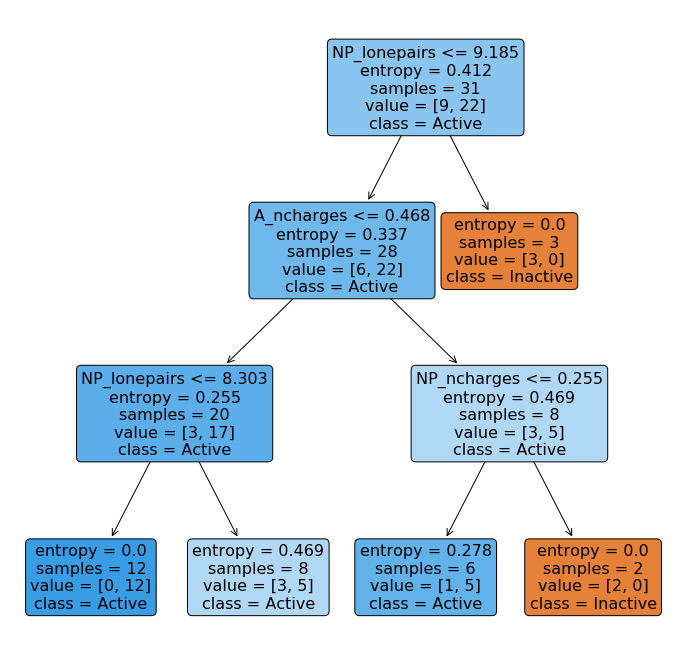

In [10]:
fig = plt.figure(figsize=(12,12))
ax = plt.axes()
plot_tree(dt, ax=ax, filled=True, feature_names=ml_cols, class_names=['Inactive', 'Active'], rounded=True, rotate=True, fontsize=Z-4)
plt.show()
plt.close()

In [11]:
confusion_matrix([0,1,1], [0,0,0])

array([[1, 0],
       [2, 0]], dtype=int64)

# Optimize Sensspec

In [58]:
metric = 0
for i in range(1000):
    dt = DecisionTreeClassifier(max_depth=3, random_state=i, splitter='random')
    dt.fit(X_set, Y_set)
    Y_pred = dt.predict(X_set)
    confusion = confusion_matrix(Y_set, Y_pred)
    current_metric = sensitivity(confusion)+specificity(confusion)  #Quality metric
    if current_metric > metric:
        best_state = i*1
        metric = current_metric*1
dt = DecisionTreeClassifier(max_depth=3, random_state=best_state, splitter='random')
dt.fit(X_set, Y_set)
Y_pred = dt.predict(X_set)
confusion = confusion_matrix(Y_set, Y_pred)
print("Accuracy: {:.2f}".format(accuracy(confusion)))
print("Sensitivity: {:.2f}".format(sensitivity(confusion)))
print("Specificity: {:.2f}".format(specificity(confusion)))

Accuracy: 0.84
Sensitivity: 0.77
Specificity: 1.00


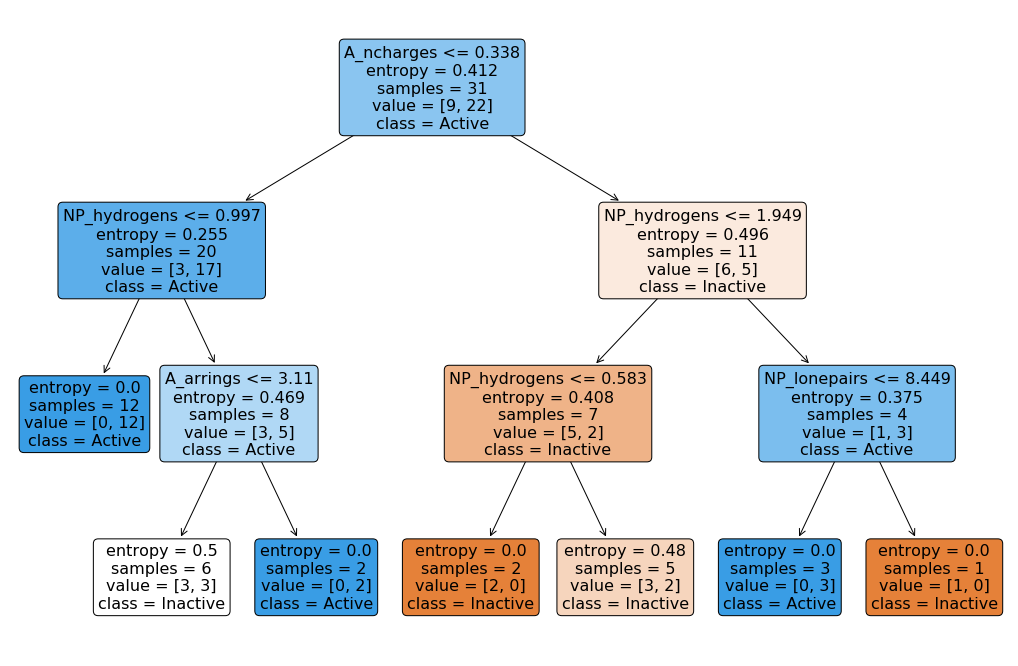

In [61]:
fig = plt.figure(figsize=(18,12))
ax = plt.axes()
plot_tree(dt, ax=ax, filled=True, feature_names=ml_cols, class_names=['Inactive', 'Active'], rounded=True, rotate=True, fontsize=Z-4)
plt.show()
plt.close()